In [1]:
import IPython.display
!pwd

/home/guest/Desktop/faceSwap2


In [2]:
# For GPU Enabled Runtime
# Install PyTorch
!sudo pip install torch torchvision

# Install onnxruntime-gpu
!sudo pip install onnxruntime-gpu

# Install InsightFace
!sudo pip install insightface

# Download the model CUDA
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64

# Set up git user name and email

!git config --global user.email "cheatedepk@gmail.com"
!git config --global user.name "epk2112"

# Clear the output of the cell
IPython.display.clear_output()

In [ ]:
# ## FOR CPU RUNTIME
# # Install Onnxruntime and Insightface

# !sudo pip install onnxruntime
# !sudo pip install insightface

# # Set up git user name and email

# !git config --global user.email "cheatedepk@gmail.com"
# !git config --global user.name "epk2112"

# # Clear the output of the cell
# IPython.display.clear_output()


In [3]:
# Install the CUDA toolkit

!sudo dpkg -i cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64
!sudo apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!sudo apt-get update
!sudo apt-get install cuda-9-2

(Reading database ... 179424 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64 ...
Unpacking cuda-repo-ubuntu1710-9-2-local (9.2.148-1) over (9.2.148-1) ...
Setting up cuda-repo-ubuntu1710-9-2-local (9.2.148-1) ...
OK
Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease     
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease             
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease                 
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease               
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease           
Hit:9 http://ppa.launchpad.net/graphics-d

In [4]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

# Import Torch (if you have GPU)
import torch

import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image


# Show the version of insightface and Numpy

print('insightface', insightface.__version__)
print('numpy', np.__version__)


# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is not available on this system.")

insightface 0.7.3
numpy 1.22.4


### Step 1: Detect Faces

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
find model: /home/guest/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cud

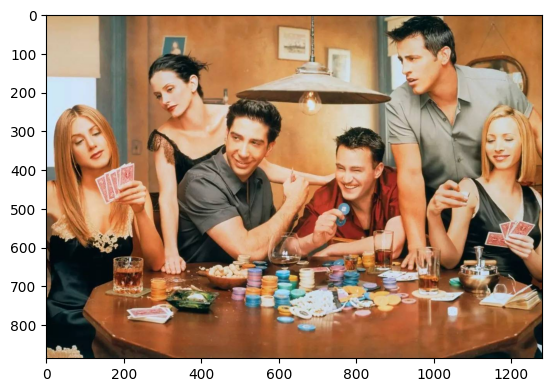

In [6]:
app = FaceAnalysis(name='buffalo_l',providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(640, 640))

# Plot an example image
img = ins_get_image('t1')
plt.imshow(img[:, :, ::-1])
plt.show()

In [7]:
# Get faces from the image
faces = app.get(img)

# show the dictionary array of faces
# faces

# Show the number of faces detected
print('faces detected:', len(faces))

# See the faces keys
faces[0].keys()

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


faces detected: 6


dict_keys(['bbox', 'kps', 'det_score', 'landmark_3d_68', 'pose', 'landmark_2d_106', 'gender', 'age', 'embedding'])

### Crop and Plot Faces

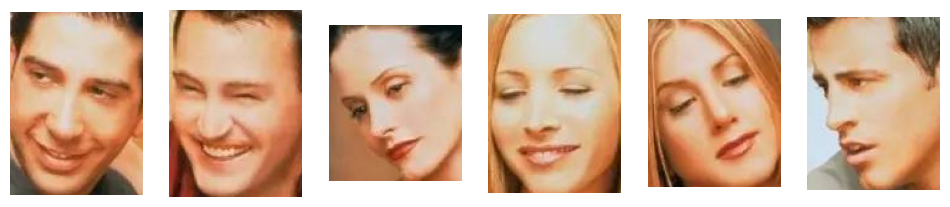

In [8]:
# Retrieve an image using the function ins_get_image('t1')
img = ins_get_image('t1')

# Create a figure with subplots using the subplots() function, 
# with the number of subplots equal to the number of faces detected
fig, axs = plt.subplots(1, len(faces), figsize=(12, 5))

# Iterate over each face detected
for i, face in enumerate(faces):
    # Extract the bounding box coordinates using the bbox key in the face dictionary
    bbox = face['bbox']
    # Convert the bounding box coordinates to integers
    bbox = [int(b) for b in bbox]
    # Crop the image using the bounding box coordinates and 
    # display it in the corresponding subplot using the imshow() function
    axs[i].imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
    # Turn off the axis display for each subplot using the axis() function
    axs[i].axis('off')

### Step 2: Face Swapping

In [10]:
swapper = insightface.model_zoo.get_model('inswapper_128.onnx',download=False,download_zip=False)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
inswapper-shape: [1, 3, 128, 128]


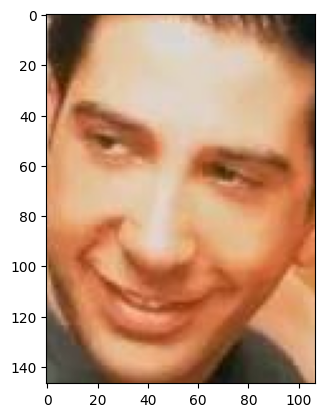

In [11]:
# Get any Source face and plot It
source_face = faces[0]
bbox = source_face['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
plt.show()

### Swap and Plot the Swapped Faces

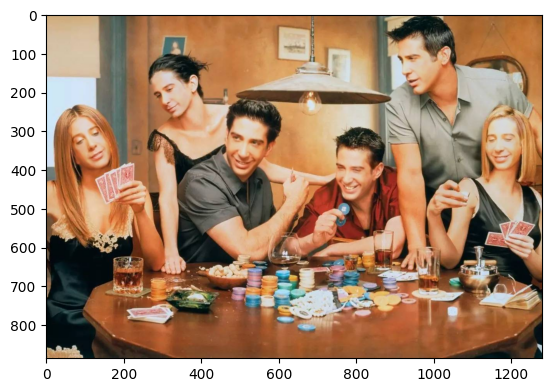

In [12]:
res = img.copy()
for face in faces:
    # Swap the faces
    res = swapper.get(res, face, source_face, paste_back=True) 
    
# Plot the result
plt.imshow(res[:,:,::-1])
plt.show()

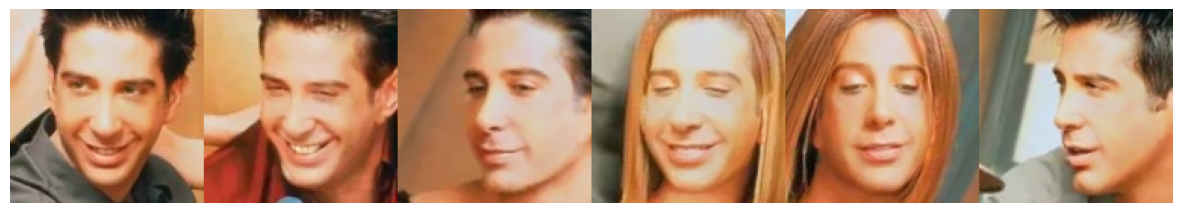

In [13]:
# Loop over all the faces and plot them Individually
res = []
for face in faces:
    _img, _ = swapper.get(img.copy(), face, source_face, paste_back=False)
    res.append(_img)
res = np.concatenate(res, axis=1)
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(res[:,:,::-1])
ax.axis('off')
plt.show()


### Put My Face on  or Any Other Face

In [23]:
# Download a sample images using wget
_ = !wget -O the_rock.jpg 'https://ntvb.tmsimg.com/assets/assets/235135_v9_bb.jpg'
_ = !wget -O vin_diesel.jpg 'https://cdn.justjared.com/wp-content/uploads/2015/10/diesel-possibly/vin-diesel-talks-about-possibly-starring-in-marvels-inhumans-02.jpg'

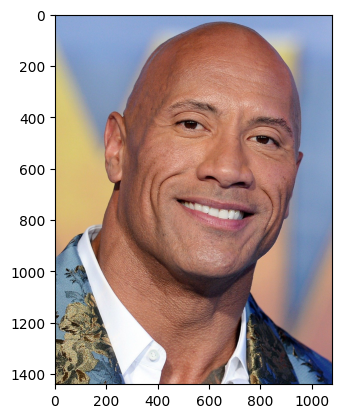

In [14]:
# Show the downloaded images
rob = cv2.imread('the_rock.jpg')
plt.imshow(rob[:,:,::-1])
plt.show()

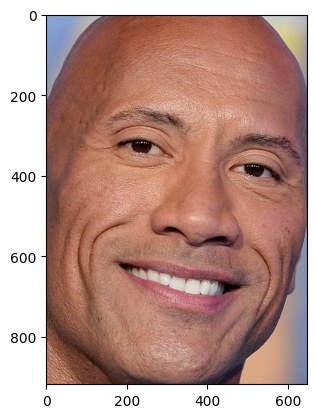

In [15]:
### 1. Detect and Save my Face

rob_faces = app.get(rob)
assert len(rob_faces) == 1
rob_face = rob_faces[0]
bbox = rob_face['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(rob[bbox[1]:bbox[3],bbox[0]:bbox[2],::-1])
plt.show()

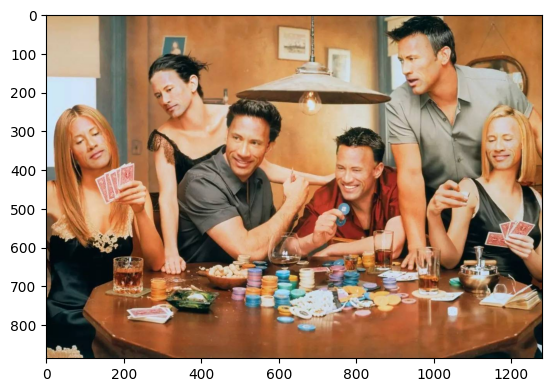

In [16]:
### 2. Detect Friend's faces

faces = app.get(img)

### 3. Swap my face for theirs on the image

res = img.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)
plt.imshow(res[:,:,::-1])
plt.show() 

## Function to Swap Two Faces on two Different Images 

In [17]:
def swap_n_show(img1_fn, img2_fn, app, swapper,
                plot_before=True, plot_after=True):
    """
    Uses face swapper to swap faces in two different images.
    
    plot_before: if True shows the images before the swap
    plot_after: if True shows the images after the swap
    
    returns images with swapped faces.
    
    Assumes one face per image.
    """
    img1 = cv2.imread(img1_fn)
    img2 = cv2.imread(img2_fn)
    
    if plot_before:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1[:,:,::-1])
        axs[0].axis('off')
        axs[1].imshow(img2[:,:,::-1])
        axs[1].axis('off')
        plt.show()
    
    # Do the swap
    face1 = app.get(img1)[0]
    face2 = app.get(img2)[0]
    
    img1_ = img1.copy()
    img2_ = img2.copy()
    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img2_ = swapper.get(img2_, face2, face1, paste_back=True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1_[:,:,::-1])
        axs[0].axis('off')
        axs[1].imshow(img2_[:,:,::-1])
        axs[1].axis('off')
        plt.show()
    return img1_, img2_

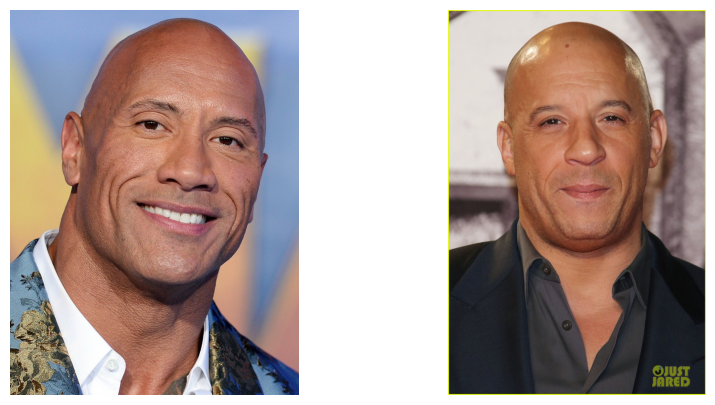

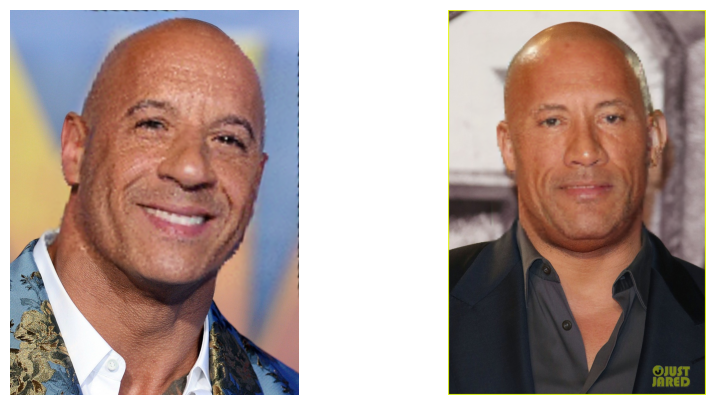

In [18]:
_ = swap_n_show('the_rock.jpg', 'vin_diesel.jpg', app, swapper)

In [26]:
# Test for Nandy and Zuchu

# Download a sample images using wget
_ = !wget -O nandy.jpg 'https://www.citimuzik.com/wp-content/uploads/2022/09/293873478_436803325007231_4825734171068936081_n-1-810x1012.jpg'
_ = !wget -O zuchu.jpg 'https://i.pinimg.com/736x/93/a1/fa/93a1fafb70deb6af9d7fdee86a697ce1.jpg'

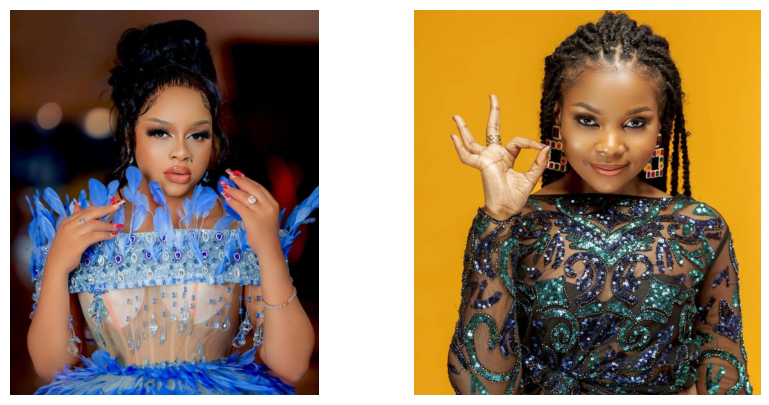

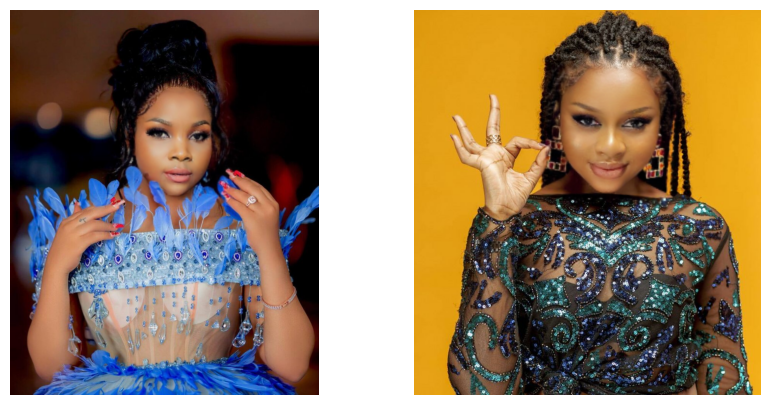

In [19]:
_ = swap_n_show('nandy.jpg', 'zuchu.jpg', app, swapper)

## Swap two faces on the same Image

In [20]:
def swap_n_show_same_img(img1_fn,
                         app, swapper,
                         plot_before=True,
                         plot_after=True):
    """
    Uses face swapper to swap faces in the same image.
    
    plot_before: if True shows the images before the swap
    plot_after: if True shows the images after the swap
    
    returns images with swapped faces.
    
    Assumes one face per image.
    """
    img1 = cv2.imread(img1_fn)
    
    if plot_before:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(img1[:,:,::-1])
        ax.axis('off')
        plt.show()
    
    # Do the swap
    faces = app.get(img1)
    face1, face2 = faces[0], faces[1]
    
    img1_ = img1.copy()
    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img1_ = swapper.get(img1_, face2, face1, paste_back=True)
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(img1_[:,:,::-1])
        ax.axis('off')
        plt.show()
    return img1_

In [1]:
# Download a sample images using wget
_ = !wget -O psquare.jpg 'https://www.naijaloaded.com.ng/wp-content/uploads/2016/02/P-Square.jpg'

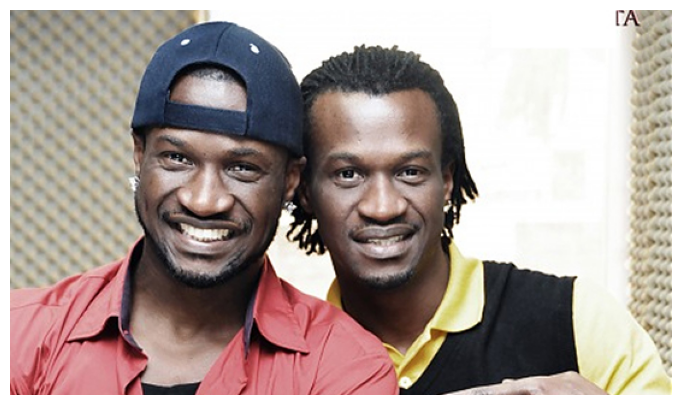

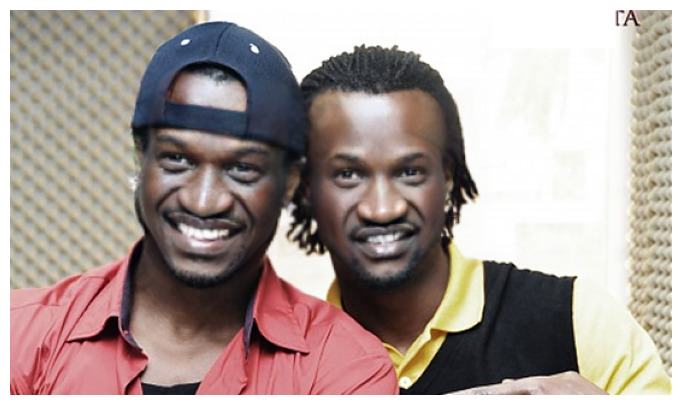

In [21]:
_ = swap_n_show_same_img('psquare.jpg', app, swapper)